# Project - Unsupervised Learning

### AllLife Credit Card Customer Segmentation Background:
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the bank poorly. Based on this, the Operations team wants to upgrade the service delivery model to ensure that customers queries are resolved faster. The Head of Marketing and the Head of Delivery both decide to reach out to the Data Science team for help.

### Objective:
To identify different segments in the existing customers based on their spending patterns as well as past interaction with the bank.

### Key Questions:
1. How many different segments of customers are there?
2. How are these segments different from each other?
3. What are your recommendations to the bank on how to better market to and service these customers? 

### Data Description: 
Data is of various customers of a bank with their credit limit, the total number of credit cards the customer has, and different channels through which customer has contacted the bank for any queries, different channels include visiting the bank, online and through a call center.


### Importing Necessary Libraries

In [1]:
# Libraries for numerical computation, data manipulation and graphing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries to transform data, cluster the data and evaluate the goodness of the technique
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet
from scipy.spatial.distance import pdist, cdist
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# displaying the graphs in Jupyter Notebooks and making them look pretty
%matplotlib inline
sns.set(color_codes=True)

**Loading Data Sheet**

In [2]:
# Reading data from the excel file
dfCredit = pd.read_excel("Credit Card Customer Data.xlsx")

**Basic Data Summary**

In [3]:
# Printing the number of rows and columns in the dataset
dfCredit.shape

(660, 7)

There are 660 rows or customers in the dataset with seven different columns.

In [4]:
# Displaying basic information about each column
dfCredit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


There appears to be no null values.  Every column is a numerical integer.  The `Sl_No` and `Customer Key` are most likely not real variables, and instead just unique identifiers for each customer.

In [5]:
dfCredit.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [6]:
dfCredit.tail()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
655,656,51108,99000,10,1,10,0
656,657,60732,84000,10,1,13,2
657,658,53834,145000,8,1,9,1
658,659,80655,172000,10,1,15,0
659,660,80150,167000,9,0,12,2


`Sl_No` and `Customer_Key` are unique values that do not give us any useful information for a customer.  We will drop these two columns.

In [7]:
# Removing the two useless columns from the dataset permantly
dfCredit.drop(columns=["Sl_No","Customer Key"], inplace=True)

**Checking for rows that are repeated in the dataset.**

In [8]:
# Printing the total number of duplicated rows
dfCredit.duplicated().sum()

11

Eleven of the rows are duplicates in the dataset.  Since a customer should only be included once, we will drop the duplicate rows.

In [9]:
# Removing the duplicate rows permantly from the dataset
dfCredit.drop_duplicates(inplace=True)

In [10]:
dfCredit.shape

(649, 5)

We now have only 649 unique customers and 5 columns that contain information we can use.

**Five Number Data Summary**

In [11]:
dfCredit.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,649.0,34878.274268,37813.736638,3000.0,11000.0,18000.0,49000.0,200000.0
Total_Credit_Cards,649.0,4.708783,2.173763,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,649.0,2.397535,1.625148,0.0,1.0,2.0,4.0,5.0
Total_visits_online,649.0,2.624037,2.952888,0.0,1.0,2.0,4.0,15.0
Total_calls_made,649.0,3.590139,2.877911,0.0,1.0,3.0,5.0,10.0


- The average credit limit for customers is skewed highly to the right.
    - `Avg_Credit_Limit` has a standard deviation larger than the mean so this feature has a very large spread.
    - The maximum value is 200,000 which is rather large.
- Most customers have 5 or more credit cards.
    - `Total_Credit_Cards` is skewed to the left.
- At least one customer has zero visits to the bank.
    - `Total_visits_bank` is skewed to the right, indicating there is a tail on the higher number of visits.
- At least 75% of customers visited the bank online four or less times.
    - There are customers on the high end with 15 visits online.
- `Total_calls_made` is skewed to the right.
    - On the highest end, there are customers who made ten calls to the bank.
    - Most customers made three or less calls.

## Univariate EDA

**Custom function to plot a histogram and a boxplot for a given feature.**

In [12]:
# Custom function for graphing histograms and boxplots for each feature
def histbox(feature):
    
    # Initializing two different graphs located side by side of one another
    fig, (box, hist) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    
    mean = np.round(dfCredit[feature].mean(), 2)
    median = np.round(dfCredit[feature].median(), 2)
        
    # Boxplot of the given feature
    sns.boxplot(x=dfCredit[feature], ax=box)
    
    # Displaying the mean and median of the feature on the graph
    box.axvline(x=mean, color="g", linestyle="dashed", label="mean: " + str(mean))
    box.axvline(x=median, color="r", linestyle="dashdot", label="median: " + str(median))
    box.legend() # Displaying the legend on the graph
    
    # Histogram of the given feature
    sns.histplot(x=dfCredit[feature], kde=True, ax=hist)
    
    # Displaying the mean and median of the feature on the graph
    hist.axvline(x=mean, color="g", linestyle="dashed", label="mean: " + str(mean))
    hist.axvline(x=median, color="r", linestyle="dashdot", label="median: " + str(median))
    hist.legend() # Displaying the legend on the graph
    
    plt.show()

### Observations of Average Credit Limit

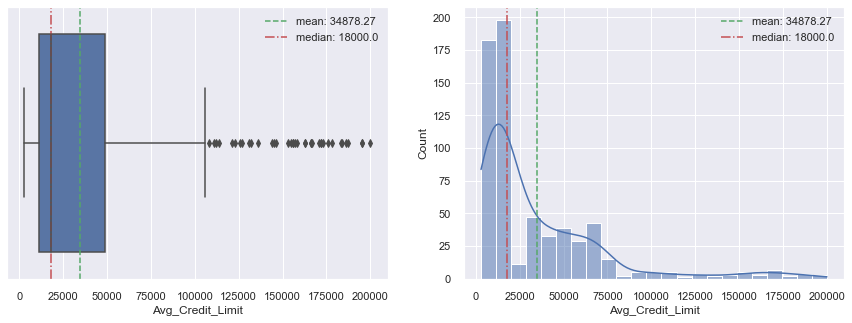

In [13]:
histbox("Avg_Credit_Limit")

- `Avg_Credit_Limit` is skewed to the right.  There are a lot of statistical outliers (values outside 1.5 IQR) on the high end.
- There appears to be two modes and then a large collection of outliers.
    - The two modes are credit limits from about 3,000 to 20,000 and then credit limits between about 25,000 and 75,000.
- There is almost a constant frequency of customers between 100,000 and 200,000.
    - These may be customers who have executive or business cards, or perhaps really high personal accounts.
- These outliers appear to follow market trends, however we will investigate further below.

### Observations of Total Credit Cards

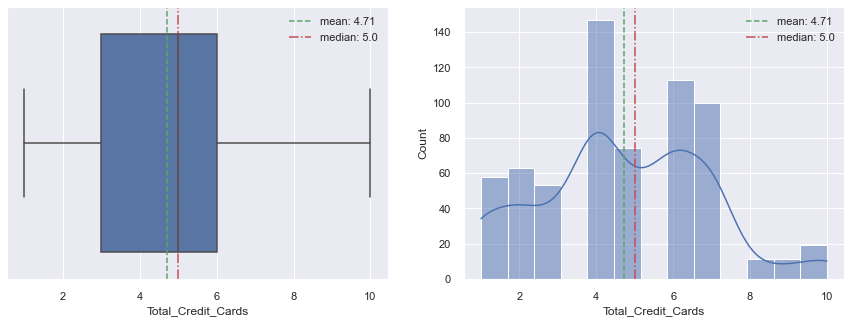

In [14]:
histbox("Total_Credit_Cards")

- The largest group of customers have four credit cards, then it decays on either side towards zero.
- There are no statistical outliers in the data as shown by the boxplot.
- The number of credit cards is slightly skewed to the left and there appears to be multiple modes.

### Observations of Total Visits to the Bank

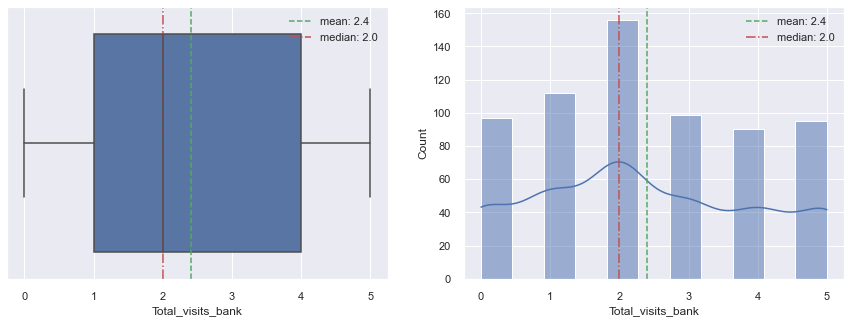

In [15]:
histbox("Total_visits_bank")

- As shown by the boxplot there are no statistical outliers.
- The data is skewed to the right of the median.
    - Most customers have visited the bank two or less times.
- Two visits is the most common group of customers.

### Observations of Total Visits Online

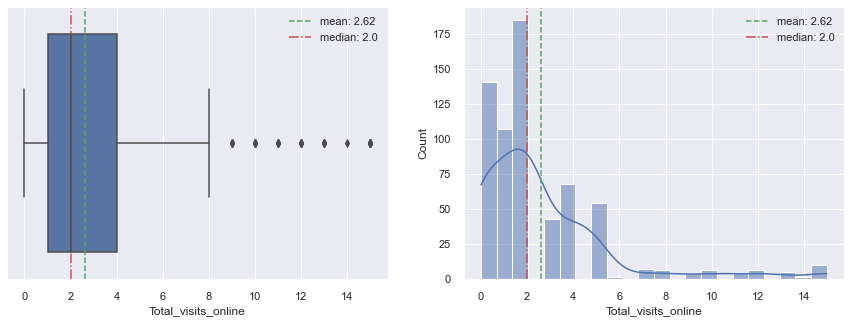

In [16]:
histbox("Total_visits_online")

- `Total_visits_online` is skewed to the right with a number of statistical outliers as show in the boxplot.
- The distribution is similar to `Avg_Credit_Limit` with two main modes and a right tail.
    - One main mode contains zero to two online visits, the other contains three to five visits.
    - The right tail has a near even frequency of customers from seven to 15 visits.
- The statistical outliers could definitely represent real market trends and expectations.  There could be customers who have more credit cards or simply use their credit card more often and check online with a greater frequency.
    - We will investigate these outliers further below.

### Observations of Total Calls Made

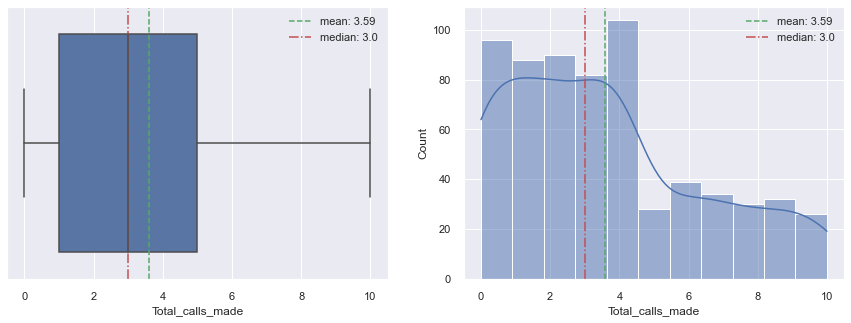

In [17]:
histbox("Total_calls_made")

- `Total_calls_made` seems to have two different sections.
    - One section contains customers who made zero to four calls.
    - The other section contains customers who placed between five and ten calls.
    - Both sections have roughly equal internal frequencies, i.e. zero through four calls all have roughly the same counts.
- There are no statistical outliers seen in the boxplot.
- This feature is skewed to the right with most customers having placed four or less calls.

## Bivariate EDA

**Comparing the correlation values between all five variables.**

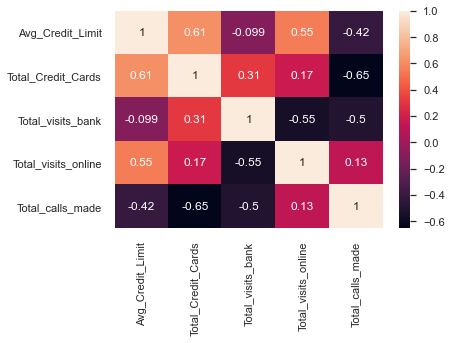

In [18]:
# Plotting a heatmap of the correlation matrix between the dataset features, showing the correlation values in each cell
sns.heatmap(data=dfCredit.corr(), annot=True);

- No two variables are strongly correlated either positively or negatively with one another.
- With a correlation of -0.65, `Total_calls_made` and `Total_Credit_Cards` has the strongest negative correlation.
    - This weakly suggests that customers who have more credit cards are less likely to call the bank.
- `Total_visits_online` and `Total_visits_bank` are slightly negatively correlated with one another with a correlation of -0.55.
    - This weakly suggests that customers who visit the bank in person are less likely to visit online.
- The strongest correlation of 0.61 is between `Total_Credit_Cards` and `Avg_Credit_Limit` weakly suggesting the more credit cards a customer possesses the higher their credit limit may be.
- To reiterate, none of these correlations are strong whatsoever.

**Scatterplots comparing all five variables.**

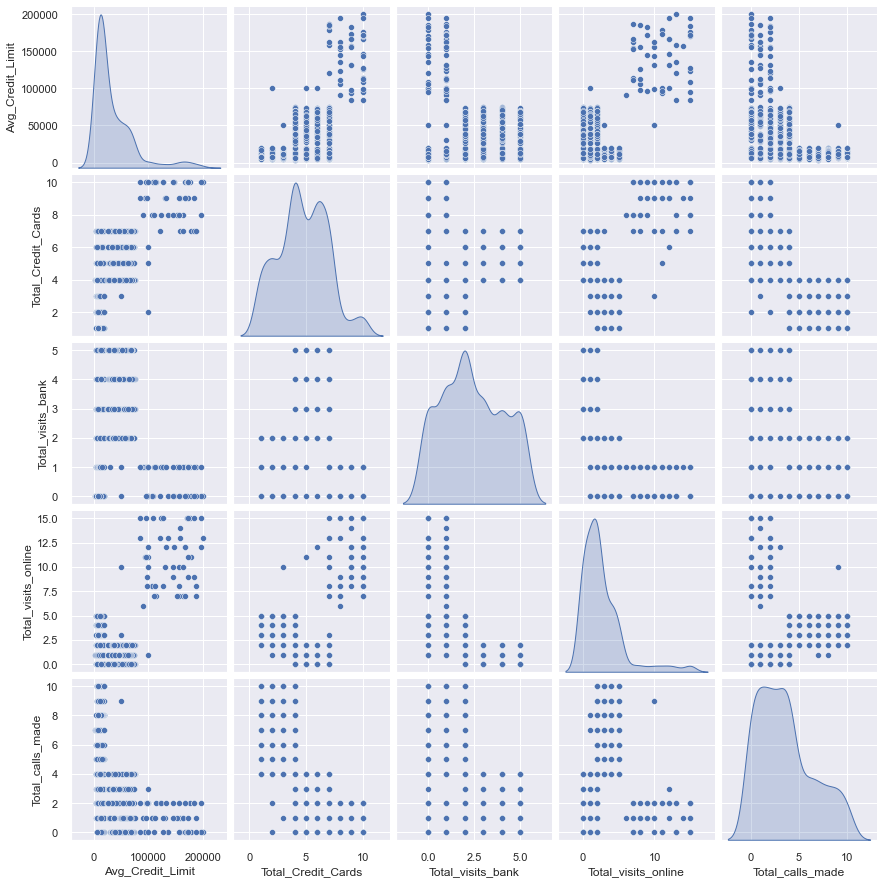

In [19]:
# Displaying scatterplots for each pair of features and kernel density estimate plots for each individual feature
sns.pairplot(data=dfCredit, diag_kind="kde");

**There appears to be distinct groupings of data in several of the graphs above.**
- `Total_visits_online` vs `Avg_Credit_Limits` seems to have a lower left group and an upper right group.
    - i.e. customers who have a low credit limit also have less online visits.
- `Total_credit_cards` vs `Total_visits_online` seems to have a lower left group and an upper right group.
    - i.e. customers who have a smaller number of credit cards visit online less.
    - This makes sense because these customers would have less they need to check on and deal with.
- `Total_credit_cards` vs `Avg_Credit_Limits` seems to have a lower left group and a upper right group as well.
    - i.e. customers with more credit cards have a larger credit limit.
- `Total_visits_online` vs `Total_calls_made` seems to have two, or perhaps even three groups.
    - The two rather definite groups are a high number of online visits with a low number of calls made followed by a low number of online visits and any number of calls made.
    - It seems that customers who take care of most of their business online have very low number of calls.
    - The second of those two groups may have two subgroups, separating them between high and low numbers of calls made.

### Investigating Average Credit Limit Statistical Outliers

There are many customers who are considered statistical outliers in regards to their average credit limit.  In the real world there are definitely customers such as business customers or more wealthy personal customers who have high credit limits.  To investigate whether we need to treat these outliers or not, we will compare the other features with regards to customers being in the outlier category or not.

**Finding the start of the outlier range in `Avg_Credit_Limit`.  This is 1.5 * iqr above the mean.**

In [20]:
q3, q1 = np.percentile(a=dfCredit["Avg_Credit_Limit"], q=[75,25]) # Calculating the 1st and third quantiles
iqr = q3 - q1 # subtracting the first and third quantiles to find the interquartile range
outlierCutoff = dfCredit["Avg_Credit_Limit"].mean() + 1.5*iqr # adding 1.5 time the IQR to the mean to find the upper start of
                                                              # outlying datapoints

# Printing the range of values of outliers for this variable
print("Statistical outliers range from", int(np.round(outlierCutoff)), "to", dfCredit["Avg_Credit_Limit"].max())

Statistical outliers range from 91878 to 200000


**Appending a new column to the dataset storing which customers are in the outlier region of `Avg_Credit_Limit`.**

In [21]:
# Creating a new column in the dataset that says whether a given row is a statistical outlier
dfCredit["Outlier_Avg_Credit_Limit"] = dfCredit["Avg_Credit_Limit"] > outlierCutoff
dfCredit.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Outlier_Avg_Credit_Limit
0,100000,2,1,1,0,True
1,50000,3,0,10,9,False
2,50000,7,1,3,4,False
3,30000,5,1,1,4,False
4,100000,6,0,12,3,True


In [22]:
# Displaying how many rows and what perecentage of rows are statistical outliers
pd.DataFrame([dfCredit["Outlier_Avg_Credit_Limit"].value_counts(),
              dfCredit["Outlier_Avg_Credit_Limit"].value_counts(normalize=True)])

,False,True
Outlier_Avg_Credit_Limit,601.00000,48.00000
Outlier_Avg_Credit_Limit,0.92604,0.07396


As shown above, about 7.4% of customers fall into the outlier average credit limit category.

**Scatterplots comparing the variables other than `Avg_Credit_Limit` while splitting the data into outliers and non-outliers.**

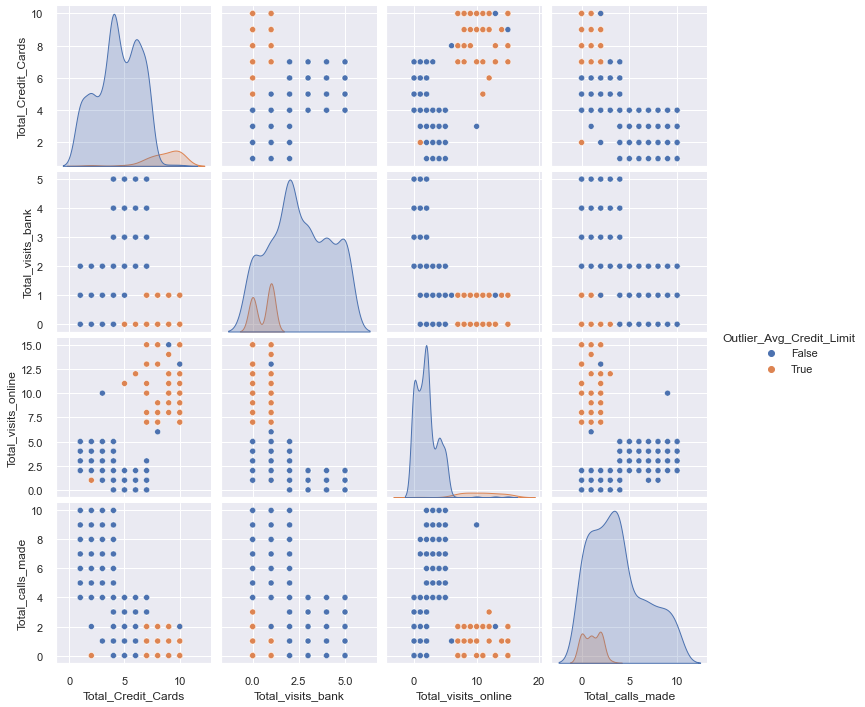

In [23]:
# Displaying a pairplot of just the columns that are not the Avg_Credit_Limit
# Then, highlighting each datapoint on whether or not they are an outlier point
sns.pairplot(data=dfCredit.drop(columns=["Avg_Credit_Limit"]), diag_kind="kde", hue="Outlier_Avg_Credit_Limit");

Nearly all of the datapoints which are outliers seem to be a part of distinct groups.  Coupled with the fact that there are customers in the world with large credit limits suggests we should not treat the outliers because they seem to contain important information for our model to learn from.

**Finding the start of the outlier range in `Total_visits_online`.  This is 1.5 * iqr above the mean.**

In [24]:
q3, q1 = np.percentile(a=dfCredit["Total_visits_online"], q=[75,25]) # Calculating the 1st and third quantiles
iqr = q3 - q1 # subtracting the first and third quantiles to find the interquartile range
outlierCutoff = dfCredit["Total_visits_online"].mean() + 1.5*iqr # adding 1.5 time the IQR to the mean to find the upper 
                                                                 # start of outlying datapoints

# Printing the range of values of outliers for this variable

print("Statistical outliers range from", int(np.round(outlierCutoff)), "to", dfCredit["Total_visits_online"].max())

Statistical outliers range from 7 to 15


**Appending a new column to the dataset storing which customers are in the outlier region of `Total_visits_online`.**

In [25]:
# Creating a new column in the dataset that says whether a given row is a statistical outlier
dfCredit["Outlier_Total_visits_online"] = dfCredit["Total_visits_online"] > outlierCutoff
dfCredit.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Outlier_Avg_Credit_Limit,Outlier_Total_visits_online
0,100000,2,1,1,0,True,False
1,50000,3,0,10,9,False,True
2,50000,7,1,3,4,False,False
3,30000,5,1,1,4,False,False
4,100000,6,0,12,3,True,True


In [26]:
# Displaying how many rows and what perecentage of rows are statistical outliers
pd.DataFrame([dfCredit["Outlier_Total_visits_online"].value_counts(),
              dfCredit["Outlier_Total_visits_online"].value_counts(normalize=True)])

,False,True
Outlier_Total_visits_online,606.000000,43.000000
Outlier_Total_visits_online,0.933744,0.066256


As shown above, about 6.6% of customers fall into the outlier average credit limit category.

**Scatterplots comparing the variables other than `Total_visits_online` while splitting the data into outliers and non-outliers.**

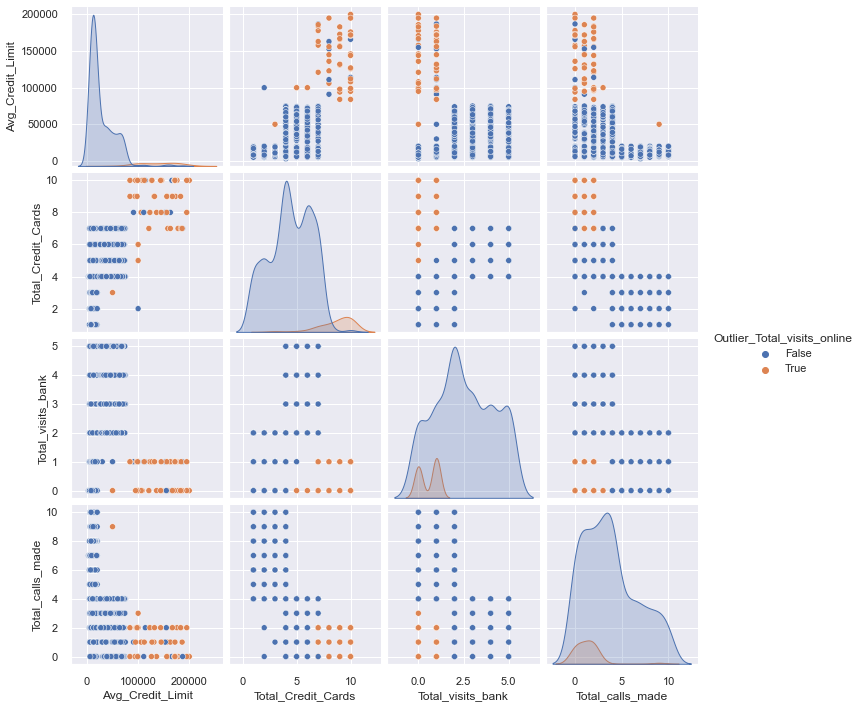

In [27]:
# Displaying a pairplot of just the columns that are not the Total_visits_online or Outlier_Avg_Credit_Limit
# Then, highlighting each datapoint on whether or not they are an outlier point
sns.pairplot(data=dfCredit.drop(columns=["Outlier_Avg_Credit_Limit", "Total_visits_online"]),
             diag_kind="kde", hue="Outlier_Total_visits_online");

Similar to before, the outliers seem to mostly be congregated in discrete groups.  We can see that these outlier customers have more credit cards, less calls made and less visits to the bank as a general rule.  Since there seems to be actual information contained in these outliers and fifteen online visits is within the realm of normal market trends, we will not treat the statistical outliers.

### Data Preparation & Scaling

First, we will drop the "outlier" columns as they simply tell us which rows were statistical outliers for a given feature and are not used for modeling.

In [28]:
# Dropping the tagged columns of whether or not a row is a statistical outlier
dfCredit.drop(columns=["Outlier_Avg_Credit_Limit", "Outlier_Total_visits_online"], inplace=True)
dfCredit.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


Clustering techniques require that our data be of similar scales.  We will scale our data to their Z-scores, i.e. project it onto the standard gaussian surface.

In [29]:
dfCreditScaled = StandardScaler().fit_transform(X=dfCredit) # Scaling the dataset using the gaussian distribution mapping
dfCreditScaled = pd.DataFrame(data=dfCreditScaled, columns=dfCredit.columns) # creating a dataframe from the scaled data
dfCreditScaled.head() # displaying the transformed data

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.723499,-1.247087,-0.860606,-0.550407,-1.248443
1,0.400209,-0.786701,-1.476410,2.499808,1.881237
2,0.400209,1.054846,-0.860606,0.127419,0.142526
3,-0.129107,0.134072,-0.860606,-0.550407,0.142526
4,1.723499,0.594459,-1.476410,3.177634,-0.205216


Above we can see that all values have been mapped to their respective Z-scores.

## K-Means Clustering

Our first main clustering technique is K-Means clustering.  In this technique, we first choose how many groups we want to segment our data into and then split our data into those groups.

Since we don't yet know what the "best" number of groups will be, we will try multiple numbers of groups and evaluate them against each other.

### Creating clusters ranging from 2 to 10 groups.

In [30]:
clusters = np.arange(2,11) # Creating a list of 2 to 10 for the number of clusters to try
models = [] # creating a blank list to store the created models in
meanDistortions = [] # creating a blank list to store the distortion scores in

# Looping through all the numbers of clusters we want to try
for i in clusters:
    model = KMeans(n_clusters=i, random_state=1) # clustering the data based on the number of clusters i
    model.fit(X=dfCreditScaled) # fitting the model to the data
    prediction = model.predict(X=dfCreditScaled) # grabbing which cluster each datapoint lives in
    
    # Calculating the mean distortion score for the current number of clusters
    distortion = sum(np.min(cdist(XA=dfCreditScaled, XB=model.cluster_centers_, metric="euclidean"), axis=1)) / dfCreditScaled.shape[0]
    
    # Storing the current model and distortion score
    models.append(model)
    meanDistortions.append(distortion)
    
    # Printing the distortion score of the current model
    print("K-means with", model.n_clusters, "clusters averaging a distortion of:", distortion)

K-means with 2 clusters averaging a distortion of: 1.4576197022077821
K-means with 3 clusters averaging a distortion of: 1.1434401208195095
K-means with 4 clusters averaging a distortion of: 1.0435538595477063
K-means with 5 clusters averaging a distortion of: 0.9877896646529043
K-means with 6 clusters averaging a distortion of: 0.9402321120333815
K-means with 7 clusters averaging a distortion of: 0.9074090300543388
K-means with 8 clusters averaging a distortion of: 0.8869431084515196
K-means with 9 clusters averaging a distortion of: 0.861584972521159
K-means with 10 clusters averaging a distortion of: 0.8439844585385387


### Elbow methods for each model metric.

**Average distortion score for each model.**

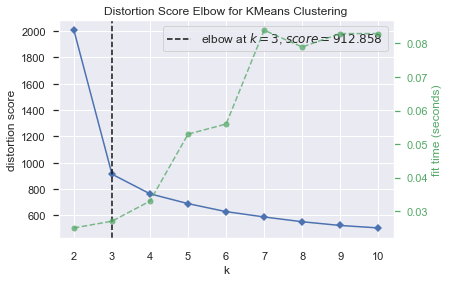

In [31]:
# Creating KMeans models for 2 through 10 clusters, calculating the distortion for each model, plotting the distortion
# This function also shows where the "elbow" most likely is which tells us most likely the "best" K value
model = KElbowVisualizer(KMeans(random_state=1), k=10)
model.fit(X=dfCreditScaled)
model.show();

The average distribution score vs number of clusters graph shows a rather sharp elbow point at three clusters.  This cluster also has the shortest fit time.  These two metrics suggest that three clusters will give us a good balance between accuracy (collecting information) and number of splits.  Too many segments will produce clusters which are not distinct from one another in a meaningful way.

**Average silhouette score for each model.**

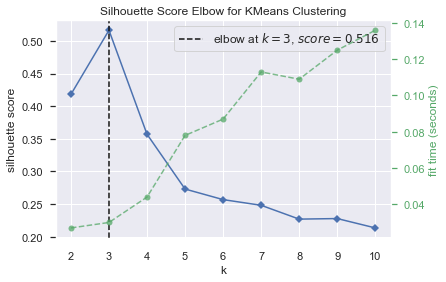

In [32]:
# Creating KMeans models for 2 through 10 clusters, calculating the average silhouette score for each model
# and finally plots the average silhouette scores
# The function also shows us where the maximum silhouette score is which tells us most likely the "best" K value
model = KElbowVisualizer(KMeans(random_state=1), metric="silhouette", k=10)
model.fit(X=dfCreditScaled)
model.show();

The average silhouette score shows a sharp maximum peak at three clusters.  The closer a silhouette score is to one means the more similar data points in each cluster are to each other.  Thus, three clusters yields groups which are most similar to themselves while different from the other groups.

Both the elbow distortion method and the average silhouette score plots suggest three clusters is best for K-Means.

**Adding columns for each of the nine K-Means models to our dataframe.**

In [33]:
# Creates a new column in the dataset for each model from K=2 through K=10, storing which cluster each row belongs to
for i, m in enumerate(models, start=2):
    dfCredit["Model"+str(i)] = m.labels_

In [34]:
dfCredit.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Model2,Model3,Model4,Model5,Model6,Model7,Model8,Model9,Model10
0,100000,2,1,1,0,1,1,1,1,1,3,3,3,0
1,50000,3,0,10,9,0,0,0,4,4,0,1,5,1
2,50000,7,1,3,4,1,1,1,1,1,3,3,3,4
3,30000,5,1,1,4,1,1,1,1,0,6,5,4,4
4,100000,6,0,12,3,1,2,2,2,2,2,2,2,2


Above we can see the cluster each data point is placed into for each model.  Below we will see how many customers are in each group.

In [35]:
# Displays how many customers are in each cluster for all the K-Means models
for i in np.arange(5,11):
    print(dfCredit.iloc[:,i].value_counts())
    print("*"*50)

1    428
0    221
Name: Model2, dtype: int64
**************************************************
1    378
0    221
2     50
Name: Model3, dtype: int64
**************************************************
0    218
1    196
3    185
2     50
Name: Model4, dtype: int64
**************************************************
1    193
0    185
3    115
4    106
2     50
Name: Model5, dtype: int64
**************************************************
5    166
3    115
0    108
4    106
1    104
2     50
Name: Model6, dtype: int64
**************************************************
0    112
6    110
4    109
1    105
3     83
5     80
2     50
Name: Model7, dtype: int64
**************************************************


Above we can see for K-Means using three clusters we have 378 customers in group 0, 221 in group 1 and 50 in group 2.  From just looking at the number of customers in each group it appears group 1 in the K=2 model was split into two groups for our K=3 model.

**Visualizing the silhouette scores for each model.**

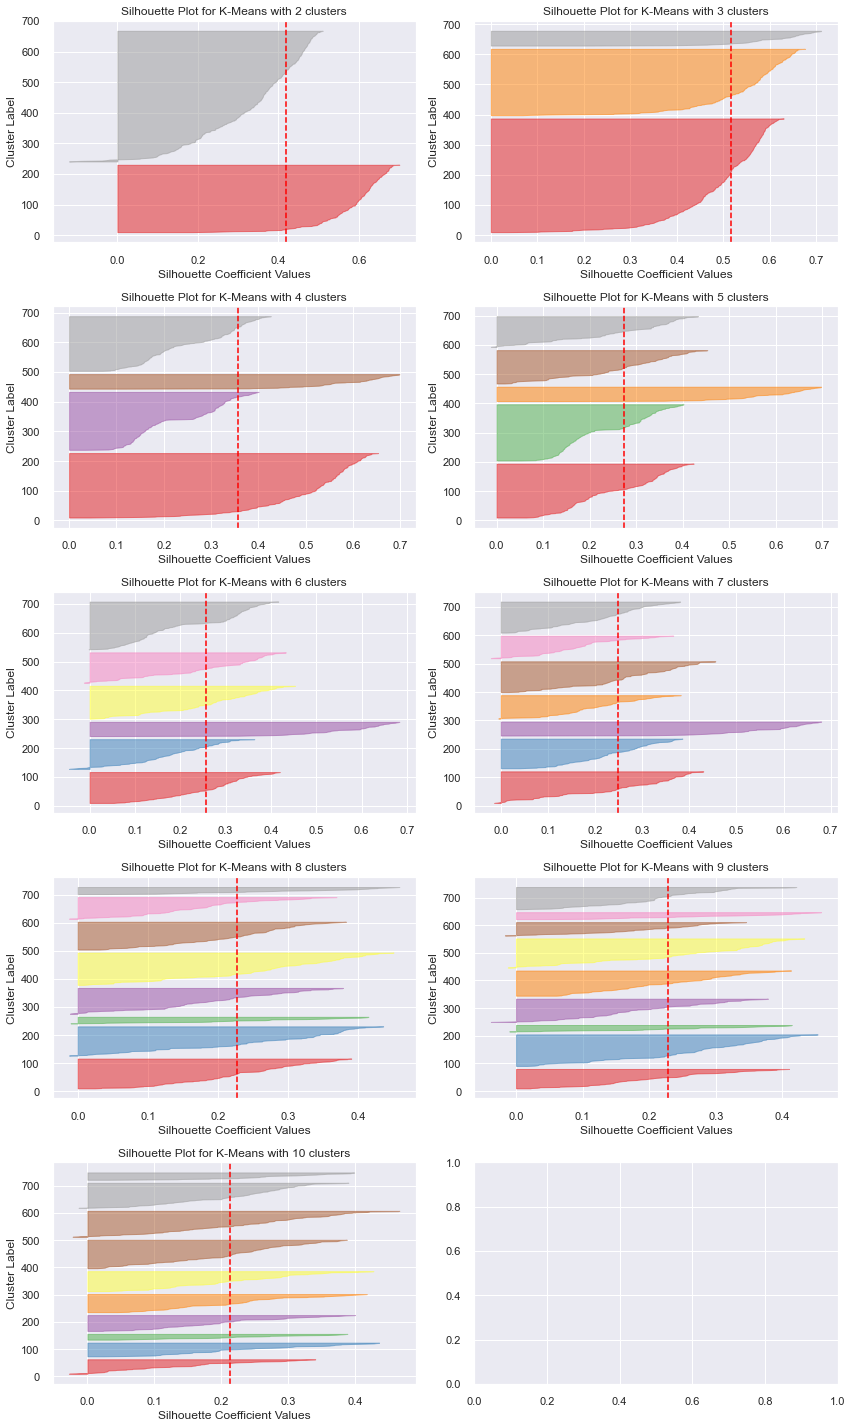

In [36]:
# Initializing 10 subplots in a 5 x 2 configuration
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,20))

# Looping through all K-Means cluster models we created
for n_clusters in clusters:
    
    currentAxes = axes[int(np.floor((n_clusters-2)/2)), np.mod((n_clusters-2),2)] # Calculates the current subplot we are on
    currentAxes.set_title("Silhouette Plot for K-Means with "+str(n_clusters) + " clusters") # sets the graph's title
    currentAxes.set_ylabel("Cluster Label") # sets the graph's y-axis label
    currentAxes.set_xlabel("Silhouette Coefficient Values") # sets the graph's x-axis label
    
    # Creates a graph visualizing the silhouette scores for each datapoint in each cluster for the current model
    visualizer = SilhouetteVisualizer(estimator=KMeans(n_clusters=n_clusters, random_state=1), ax=currentAxes)
    visualizer.fit(X=dfCreditScaled)

# Displays the multiplot graphs better and prints them
plt.tight_layout()
plt.show()

From the silhouette plots above, K-Means with three clusters shows the highest average silhouette score and similar silhouette scores between the three separate clusters.

### Boxplots comparing the different clusters for a few of the models.
Custom function for graphing the boxplots.

In [37]:
# Custom function to graph the boxplot for a given feature for K-Means models of clusters 2 through 5
def modelBox(feature):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10)) # initializing 4 subplots
    
    # Looping through models K=2 through K=5
    for i in np.arange(2,6):
        currentAxes = axs[int(np.floor((i-2)/2)), np.mod((i-2),2)] # Calculating the current axis we are on
        sns.boxplot(y=dfCredit[feature], x=dfCredit["Model"+str(i)], ax=currentAxes) # Graphing the boxplot for the current model
    
    # Displays the multiplot graphs better and prints them
    plt.tight_layout()
    plt.show()

### Average Credit Limit

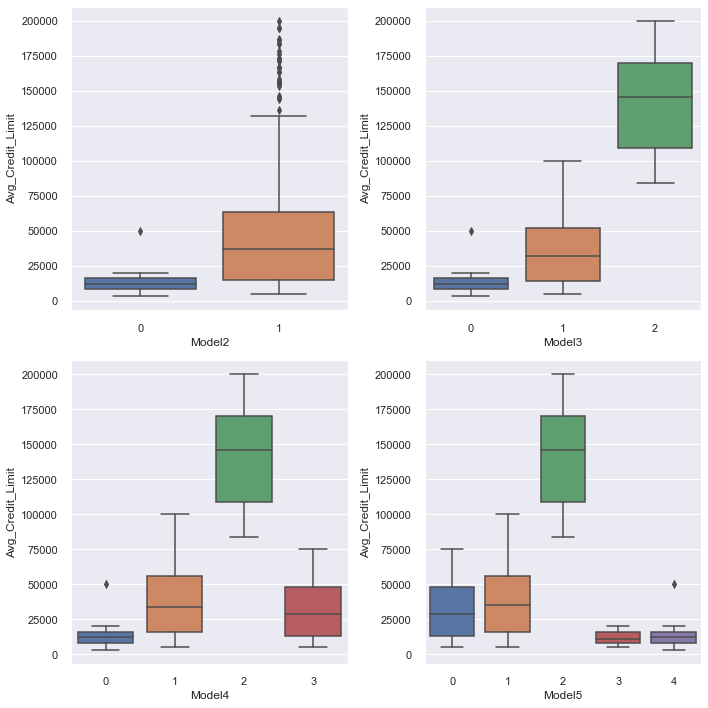

In [38]:
modelBox("Avg_Credit_Limit")

Above we can see that for `Avg_Credit_Limit` if we have more than three clusters there are at least two clusters that significantly overlap one another.  For instance, in Model4 clusters one and three have nearly the same distribution.

### Total Credit Cards

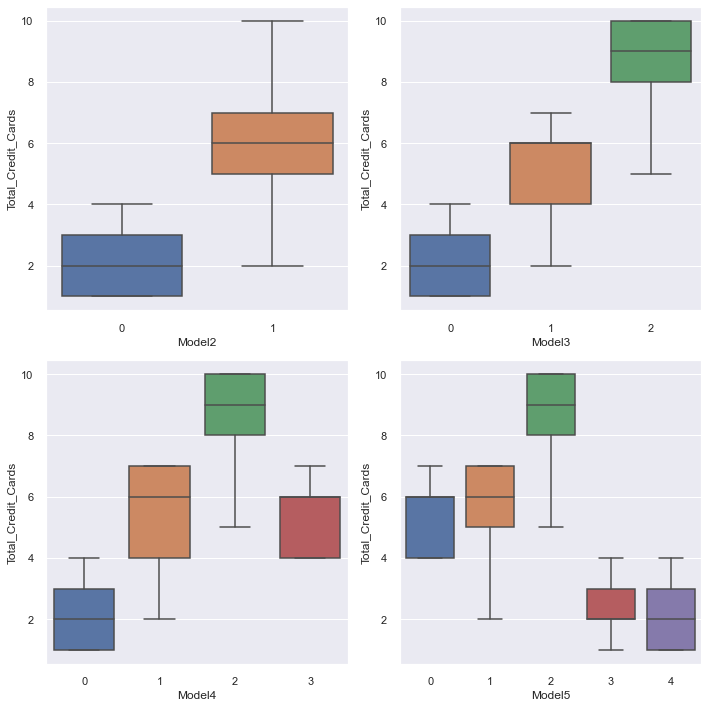

In [39]:
modelBox("Total_Credit_Cards")

As with `Avg_Credit_Limit` above three clusters we do not get distinct groups.  Also, for Model4 we  get the same clusters one and three overlapping each other significantly.

### Total Visits Bank

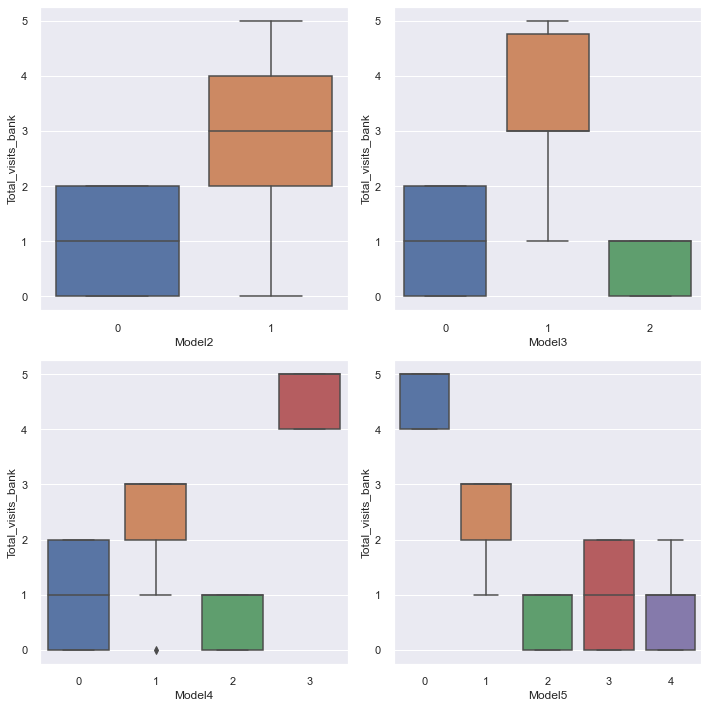

In [40]:
modelBox("Total_visits_bank")

From the boxplots above for `Total_visits_bank`, even three clusters do not give completely separate groups of customers.

### Total Calls Made

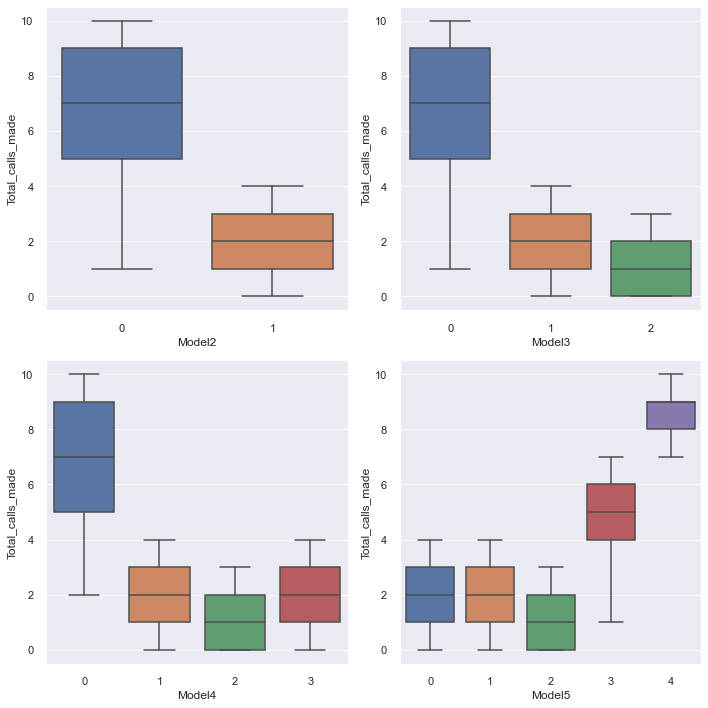

In [41]:
modelBox("Total_calls_made")

Three clusters gives the best cluster distinction again when looking at `Total_calls_made`.

### Total Visits Online

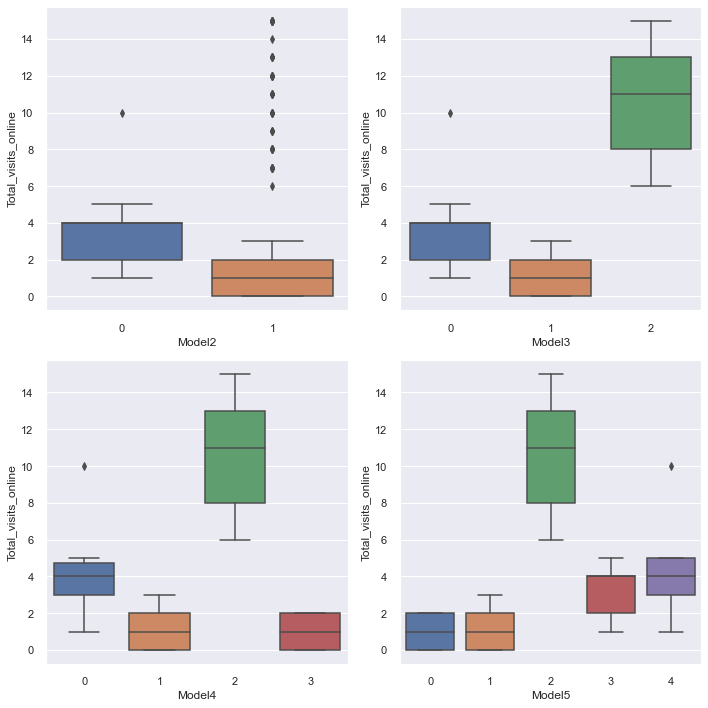

In [42]:
modelBox("Total_visits_online")

From the above plots we can see that Model3 captures the outliers of `Total_visits_online` into its own cluster, cluster 2.   For any number above three clusters we do not get distinct groups, instead clusters 1 and 3 overlap each other again.

**For K-Means clustering, the average distortion elbow method, average silhouette score and boxplots have all shown that three is most likely the best number of clusters.**

## Hierarchical Clustering

Hierarchical clustering works in one of two ways.
- Agglomerative starts with all data points being separate then merges the "closest" pairs together step by step until there is only one cluster left.
- Divisive starts with all data points in the same group and then splits into two groups, continuing to split until each data point is its own group.
- Once all of these clusters have been created, we then can choose the number of clusters we want.

We will create models for each method and metric pair and then choose the best model and number of clusters.  The higher the cophenetic correlation score the better that method and metric is thought to be.

In [43]:
# Dataframe to store the performance of each clustering technique.
dfHierarchical = pd.DataFrame(columns=["Metric", "Method", "Cophent"])

**Looping through different methods which use metrics other than Euclidean distances.**

In [44]:
metrics = ['chebyshev','mahalanobis','cityblock'] # List of the different metrics to loop through
methods = ['single', 'complete', 'average', 'weighted'] # List of the different methods to loop through

highCophenetCorr = 0 # Initializing a tracker to store the highest Cophenetic Correlation value
highMetricMethod = [0,0] # Initializing a tracker to store metric and method for the best technique

rowNum = 0 # Keeping track of which row we are on to append to the data frame

# Looping through all metrics and methods
for metric in metrics:
    for method in methods:
        Z = linkage(y=dfCreditScaled, method=method, metric=metric) # Finding the linkage scores for the current method and metric
        
        c, cophDists = cophenet(Z=Z, Y=pdist(X=dfCreditScaled, metric=metric)) # calculating the cophentic correlation values

        dfHierarchical.loc[rowNum] = {"Metric":metric, "Method":method, "Cophent":c} # storing each model in the dataframe
        rowNum = rowNum+1 # increasing the row number by one in order to append to the next row next time
        
        # Storing the current cophenetic correlation vale and metric and method if it is better than the previous ones
        if highCophenetCorr < c:
            highCophenetCorr = c
            highMetricMethod[0] = metric
            highMetricMethod[1] = method

**Looping through the methods which use the Euclidean distance metric.**

In [45]:
methods = ['single', 'complete', 'average','median','ward', 'weighted'] # List of the different methods to loop through
metric = "euclidean" # The only metric that will work for all of the above methods

# Looping through all of the methods
for method in methods:
    Z = linkage(y=dfCreditScaled, method=method) # Finding the linkage scores for the current method and metric
    
    c, cophDists = cophenet(Z=Z, Y=pdist(X=dfCreditScaled)) # calculating the cophentic correlation values
    
    dfHierarchical.loc[rowNum] = {"Metric":metric, "Method":method, "Cophent":c} # storing each model in the dataframe
    rowNum = rowNum+1 # increasing the row number by one in order to append to the next row next time
    
    # Storing the current cophenetic correlation vale and metric and method if it is better than the previous ones
    if highCophenetCorr < c:
        highCophenetCorr = c
        highMetricMethod[0] = "euclidean"
        highMetricMethod[1] = method

In [46]:
# Displaying the score, metric and method for the "best" technique
print("The clustering technique using", highMetricMethod[0], "metric and ", highMetricMethod[1], "method gave the highest cophenetic score of", np.round(highCophenetCorr, 3))
# Displaying the dataframe of all of the Hierarchical models and highlighting the best score
dfHierarchical.style.highlight_max(subset="Cophent", axis=0)

The clustering technique using euclidean metric and  average method gave the highest cophenetic score of 0.897


,Metric,Method,Cophent
0,chebyshev,single,0.710813
1,chebyshev,complete,0.831173
2,chebyshev,average,0.868714
3,chebyshev,weighted,0.865396
4,mahalanobis,single,0.630811
5,mahalanobis,complete,0.658302
6,mahalanobis,average,0.742564
7,mahalanobis,weighted,0.672507
8,cityblock,single,0.709821
9,cityblock,complete,0.869253


From all of the hierarchical clustering methods and metric, we see that using the 'Euclidean' metric and the 'Average' method obtained the highest cophenetic score and thus most likely yields the best clusters.

### Visualizing the Dendrogram for the best Hierarchical Clustering

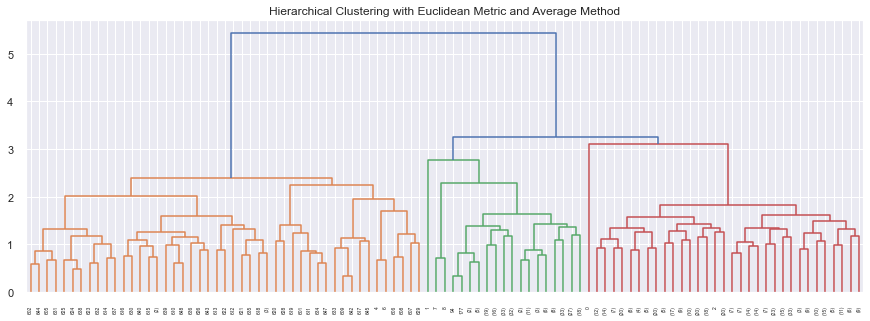

In [47]:
plt.figure(figsize=(15,5)) # Sizing the graph
Z = linkage(y=dfCreditScaled, method=highMetricMethod[1], metric=highMetricMethod[0]) # Calculating the linkage for the best model
dendrogram(Z=Z, p=7, truncate_mode="level", color_threshold=3.2) # Creating the dendrogram tree for the best model
                                                                 # only showing the first 7 levels to save time and legibility
plt.title("Hierarchical Clustering with Euclidean Metric and Average Method") # setting the title of the graph
plt.show()

The orange, green and red groups are the top three clusters in this method.  We can see that this method and metric is yielding large, separate clusters which we want.

**Attaching the labels for the different clusters to their data points.**

In [48]:
bestLabels = fcluster(Z=Z, t=3.2, criterion="distance") # Grabbing which cluster each customer is in
dfCredit["EuclideanAverage"] = bestLabels # Creating a new column in the dataset storing which cluster each row belongs to
dfCredit.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Model2,Model3,Model4,Model5,Model6,Model7,Model8,Model9,Model10,EuclideanAverage
0,100000,2,1,1,0,1,1,1,1,1,3,3,3,0,3
1,50000,3,0,10,9,0,0,0,4,4,0,1,5,1,2
2,50000,7,1,3,4,1,1,1,1,1,3,3,3,4,3
3,30000,5,1,1,4,1,1,1,1,0,6,5,4,4,3
4,100000,6,0,12,3,1,2,2,2,2,2,2,2,2,1


**Viewing the number of customers in each cluster.**

In [49]:
# Displaying how many customers are in each cluster of the best model
pd.DataFrame([dfCredit["EuclideanAverage"].value_counts(),
              dfCredit["EuclideanAverage"].value_counts(normalize=True)])

,3,2,1
EuclideanAverage,379.000000,220.000000,50.000000
EuclideanAverage,0.583975,0.338983,0.077042


There are 379 customers in cluster three, 220 in cluster two and 50 in cluster one.  These are similar in number to the three clusters from the K-Means technique.

## Cluster Profiling and Comparing Techniques

Dropping unused models.

In [50]:
# Removing the unused or not-the-best models from the dataframe
dfCredit.drop(columns=["Model2", "Model4", "Model5", "Model6", "Model7", "Model8", "Model9", "Model10"], inplace=True)

### Boxplots comparing the different clusters of the hierarchical clustering.

In [51]:
# Displaying the mean values for each feature of each cluster, highlighting the maximum
dfCredit.drop(columns="Model3").groupby(by="EuclideanAverage").mean().style.highlight_max(color="lightgreen")

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
EuclideanAverage,,,,,
1,141040.000000,8.740000,0.600000,10.900000,1.080000
2,12263.636364,2.404545,0.940909,3.568182,6.904545
3,34000.000000,5.514512,3.480211,0.984169,1.997361


In [52]:
# Displaying the median values for each feature of each cluster, highlighting the maximum
dfCredit.drop(columns="Model3").groupby(by="EuclideanAverage").median().style.highlight_max(color="lightgreen")

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
EuclideanAverage,,,,,
1,145500,9,1,11,1
2,12000,2,1,4,7
3,32000,6,3,1,2


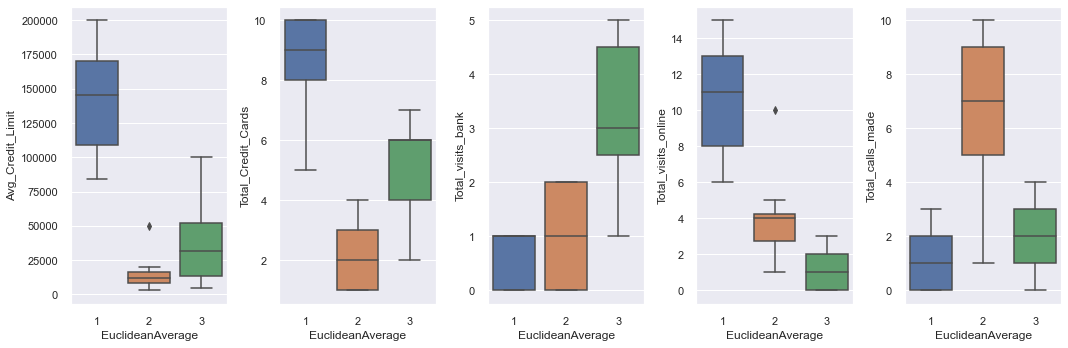

In [53]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15,5)) # Initializing 5 subplots

# Looping through all the data features
for i, col in enumerate(dfCredit.iloc[:,0:5].columns):
    # plotting a boxplot for each feature broken into the different clusters
    sns.boxplot(x=dfCredit["EuclideanAverage"], y=dfCredit[col], ax=axs[i])

# Displaying the subplots better    
plt.tight_layout()
plt.show()

**Cluster 1**
- Highest average credit limit, number of credit cards and visits online.
- Lowest visits to the bank and calls made.
- Customers who have more credit cards and higher limits use the online portal the most.

**Cluster 2**
- Highest calls made to the bank.
- Middle visits to the bank and visits online.
- Lowest average credit limit and number of credit cards.
- Customers who have the lowest credit limits and number of cards call the bank more often.

**Cluster 3**
- Highest number of visits to the bank.
- Middle average credit limit, total credit cards and total calls made.
- Lowest visits online.
- Customers who are middle of the road on credit limit and number of cards are most likely to visit the bank in person and do not use the online portal often.

### Boxplots comparing the different clusters of the K-Means clustering.

In [54]:
# Displaying the mean values for each feature of each cluster, highlighting the maximum
dfCredit.drop(columns="EuclideanAverage").groupby(by="Model3").mean().style.highlight_max(color="lightgreen")

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Model3,,,,,
0,12239.819005,2.411765,0.945701,3.561086,6.891403
1,34071.428571,5.518519,3.484127,0.981481,1.992063
2,141040.000000,8.740000,0.600000,10.900000,1.080000


In [55]:
# Displaying the median values for each feature of each cluster, highlighting the maximum
dfCredit.drop(columns="EuclideanAverage").groupby(by="Model3").median().style.highlight_max(color="lightgreen")

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Model3,,,,,
0,12000,2,1,4,7
1,32000,6,3,1,2
2,145500,9,1,11,1


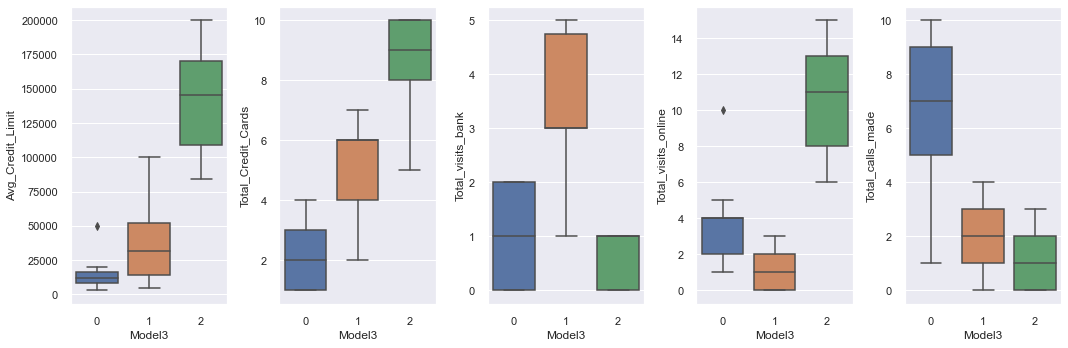

In [56]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15,5)) # Initializing 5 subplots

# Looping through all the data features
for i, col in enumerate(dfCredit.iloc[:,0:5].columns):
    # plotting a boxplot for each feature broken into the different clusters
    sns.boxplot(x=dfCredit["Model3"], y=dfCredit[col], ax=axs[i])

# Displaying the subplots better
plt.tight_layout()
plt.show()

**Cluster 2**
- Highest average credit limit, number of credit cards and visits online.
- Lowest visits to the bank and calls made.
- Customers who have more credit cards and higher limits use the online portal the most.

**Cluster 0**
- Highest calls made to the bank.
- Middle visits to the bank and visits online.
- Lowest average credit limit and number of credit cards.
- Customers who have the lowest credit limits and number of cards call the bank more often.

**Cluster 1**
- Highest number of visits to the bank.
- Middle average credit limit, total credit cards and total calls made.
- Lowest visits online.
- Customers who are middle of the road on credit limit and number of cards are most likely to visit the bank in person and do not use the online portal often.

## Comparing K-Means and Hierarchical Clustering Techniques

In looking at the means, medians and boxplots of the two different techniques, the K-Means and Hierarchical clustering techniques found virtually the same clusters.  The exact numbers used to label each cluster are simply rearranged.  Both techniques yielded three well defined, unique clusters which do not overlap significantly with one another.

## Actionable Insights & Recommendations

- Customers who have a large number of credit cards and high credit limits utilize the online portal significantly more than the other clientel.
    - Ensuring a clean, well organized online portal is key to keeping these customers happy.  If they are unable to easily manage many accounts online they will become frustrated.
    - Online ads targeting this class of customer will be viewed frequently by the intended customers.
    - Only around 8% of the customers fall into this category.
- Customers who have middle of the road credit limits and number of credit cards were most likely to visit the bank.
    - These clientel value face-to-face interaction.  Following visiting a bank in person, they are next most likely to call and least likely to utilize the online portal.
    - Investigating ways to improve the online experience for this customer set may help to save money in the long run for the bank as they will need less employee time for face-to-face interaction.
    - Advertising inside the bank for the perks of using the online portal might encourage more utilization of it for this group.
    - Around 58% of the bank's customers fall into this category so the bank may really be able to save money by shifting this group to utilizing the online banking portal.  This is the largest group of customers.
- Customers who have the lowest credit limit and number of credit cards were most likely to call the bank.
    - In order to grow these customers' number of credit cards and credit limit to increase revenue, the bank will need to advertise and communicate well over the phone.
    - If the bank is having a hard time converting these customers to a higher profitablity group the bank should increase their ability to market over the phone or strongly encourage these customers to visit the bank in person or online where the bank seems to be able to better market its products.
    - Approximately 34% of the bank's customers fall into this category.